In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import sweden
import netherlands
import saopaulo
import australia
import population_representation as poprep
from matplotlib.patches import Patch, ConnectionPatch
import matplotlib.transforms as mplt
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import regions
import geostat
import plotly.express as px
import plotly
import plotly.graph_objects as pgo
from plotly.offline import init_notebook_mode
import numpy as np

In [3]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 18.0

In [4]:
class DualNorm(object):
    def __init__(self, leftnorm=None, rightnorm=None, midpoint=1.0):
        self.leftnorm = leftnorm
        self.rightnorm = rightnorm
        self.midpoint = midpoint
    def __call__(self, value, clip=None):
        if isinstance(value, np.ndarray):
            return np.vectorize(self._norm)(value)
        else:
            return self._norm(value)
        
    def _norm(self, value):
        if value < self.midpoint:
            return self.leftnorm(value)*0.5
        else:
            return self.rightnorm(value)*0.5 + 0.5
    
    def inverse(self, value):
        if isinstance(value, np.ndarray):
            return np.vectorize(self._inverse)(value)
        else:
            return self._inverse(value)

    def _inverse(self, value):
        if value < 0.5:
            return self.leftnorm.inverse(value*2)
        else:
            return self.rightnorm.inverse((value-0.5)*2)

In [5]:
def population_representation_plot(
    ax, 
    zones, 
    cbar_ticks=None, 
    label_loc="upper center", 
    colorbar_shrink=1.0,
    colorbar_orientation="horizontal"
):
    
    
    zones_masked = zones.copy()
    zones_masked.loc[zones.twitter < 2.0, "perc_of_census"] = None
    
    minv = np.min(zones_masked.perc_of_census.dropna().values)
    maxv = np.max(zones_masked.perc_of_census.dropna().values)
    
    norm = DualNorm(
        leftnorm=colors.Normalize(minv, 1.0),
        rightnorm=colors.Normalize(1.0, maxv),
        midpoint=1.0,
    )
    
    if cbar_ticks is not None:
        cbar_ticks = [norm(t) for t in cbar_ticks]
    
    def tick_formatter(x, pos):
        f = norm.inverse(x)
        return "{:.1f}".format(f)

    zones_masked.plot(
        ax=ax, 
        column=norm(zones_masked.perc_of_census.values), 
        edgecolor='black',
        linewidth=0.1,
        cmap="bwr", 
        legend=True,
        legend_kwds={
            "orientation": colorbar_orientation,
            "format": mpl.ticker.FuncFormatter(tick_formatter),
            "ticks": cbar_ticks,
            "pad": 0.01,
            "shrink": colorbar_shrink,
        },
        missing_kwds={
            "color": "lightgrey",
        }
    )
    
    # If there is any missing data, show the legend
    if np.any(zones_masked.perc_of_census.isna()):
        p = mpl.patches.Patch(
            facecolor='lightgrey', 
            linewidth=0.1, 
            edgecolor='black', 
            label='0 or 1 Twitter user',
        )
        ax.legend(handles=[p], loc=label_loc, fontsize='15')
    ax.set_axis_off()
    
    return ax

# Sweden

In [6]:
# Load homes
swe_homes = poprep.twitter_home_locations("sweden")
mask = regions.counties.convex_hull.unary_union.convex_hull
swe_census_homes = geostat.load(mask=regions.counties.convex_hull.unary_union.convex_hull)

# Load shape files
swe_counties = regions.counties.set_index('ID')
swe_municipalities = gpd.read_file(
    "../../dbs/sweden_municipalities/sweden_municipalities.shp",
).rename(columns={"KnKod": "ID"}).set_index("ID")

# Align
swe_homes = swe_homes.to_crs(swe_census_homes.crs)
swe_counties = swe_counties.to_crs(swe_census_homes.crs)
swe_municipalities = swe_municipalities.to_crs(swe_census_homes.crs)

swe_counties = poprep.align_populations(swe_counties, swe_homes, swe_census_homes)
swe_municipalities = poprep.align_populations(swe_municipalities, swe_homes, swe_census_homes)

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



In [7]:
swe_municipalities.sort_values(by="perc_of_census", ascending=False).head(5)

KnNamn                                           geometry  twitter  \
ID                                                                            
2321        Åre  POLYGON ((4509168.024 4477219.473, 4513215.983...     13.0   
2506   Arjeplog  POLYGON ((4689913.157 4765136.547, 4695965.535...      1.0   
2031    Rättvik  POLYGON ((4592028.996 4259294.722, 4591732.768...     12.0   
0180  Stockholm  MULTIPOLYGON (((4780115.861 4050918.419, 47801...    775.0   
2404    Vindeln  POLYGON ((4779599.341 4580008.126, 4777889.507...      4.0   

      census  twitter_perc  census_perc  perc_of_census  
ID                                                       
2321   10363      0.003663     0.001047        3.497036  
2506     872      0.000282     0.000088        3.196876  
2031   10665      0.003381     0.001078        3.136626  
0180  968715      0.218371     0.097915        2.230221  
2404    5355      0.001127     0.000541        2.082298

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/geopandas/plotting.py:332: UserWarning:

The GeoSeries you are attempting to plot is empty. Nothing has been displayed.



Text(0.05, 0.8, 'B')

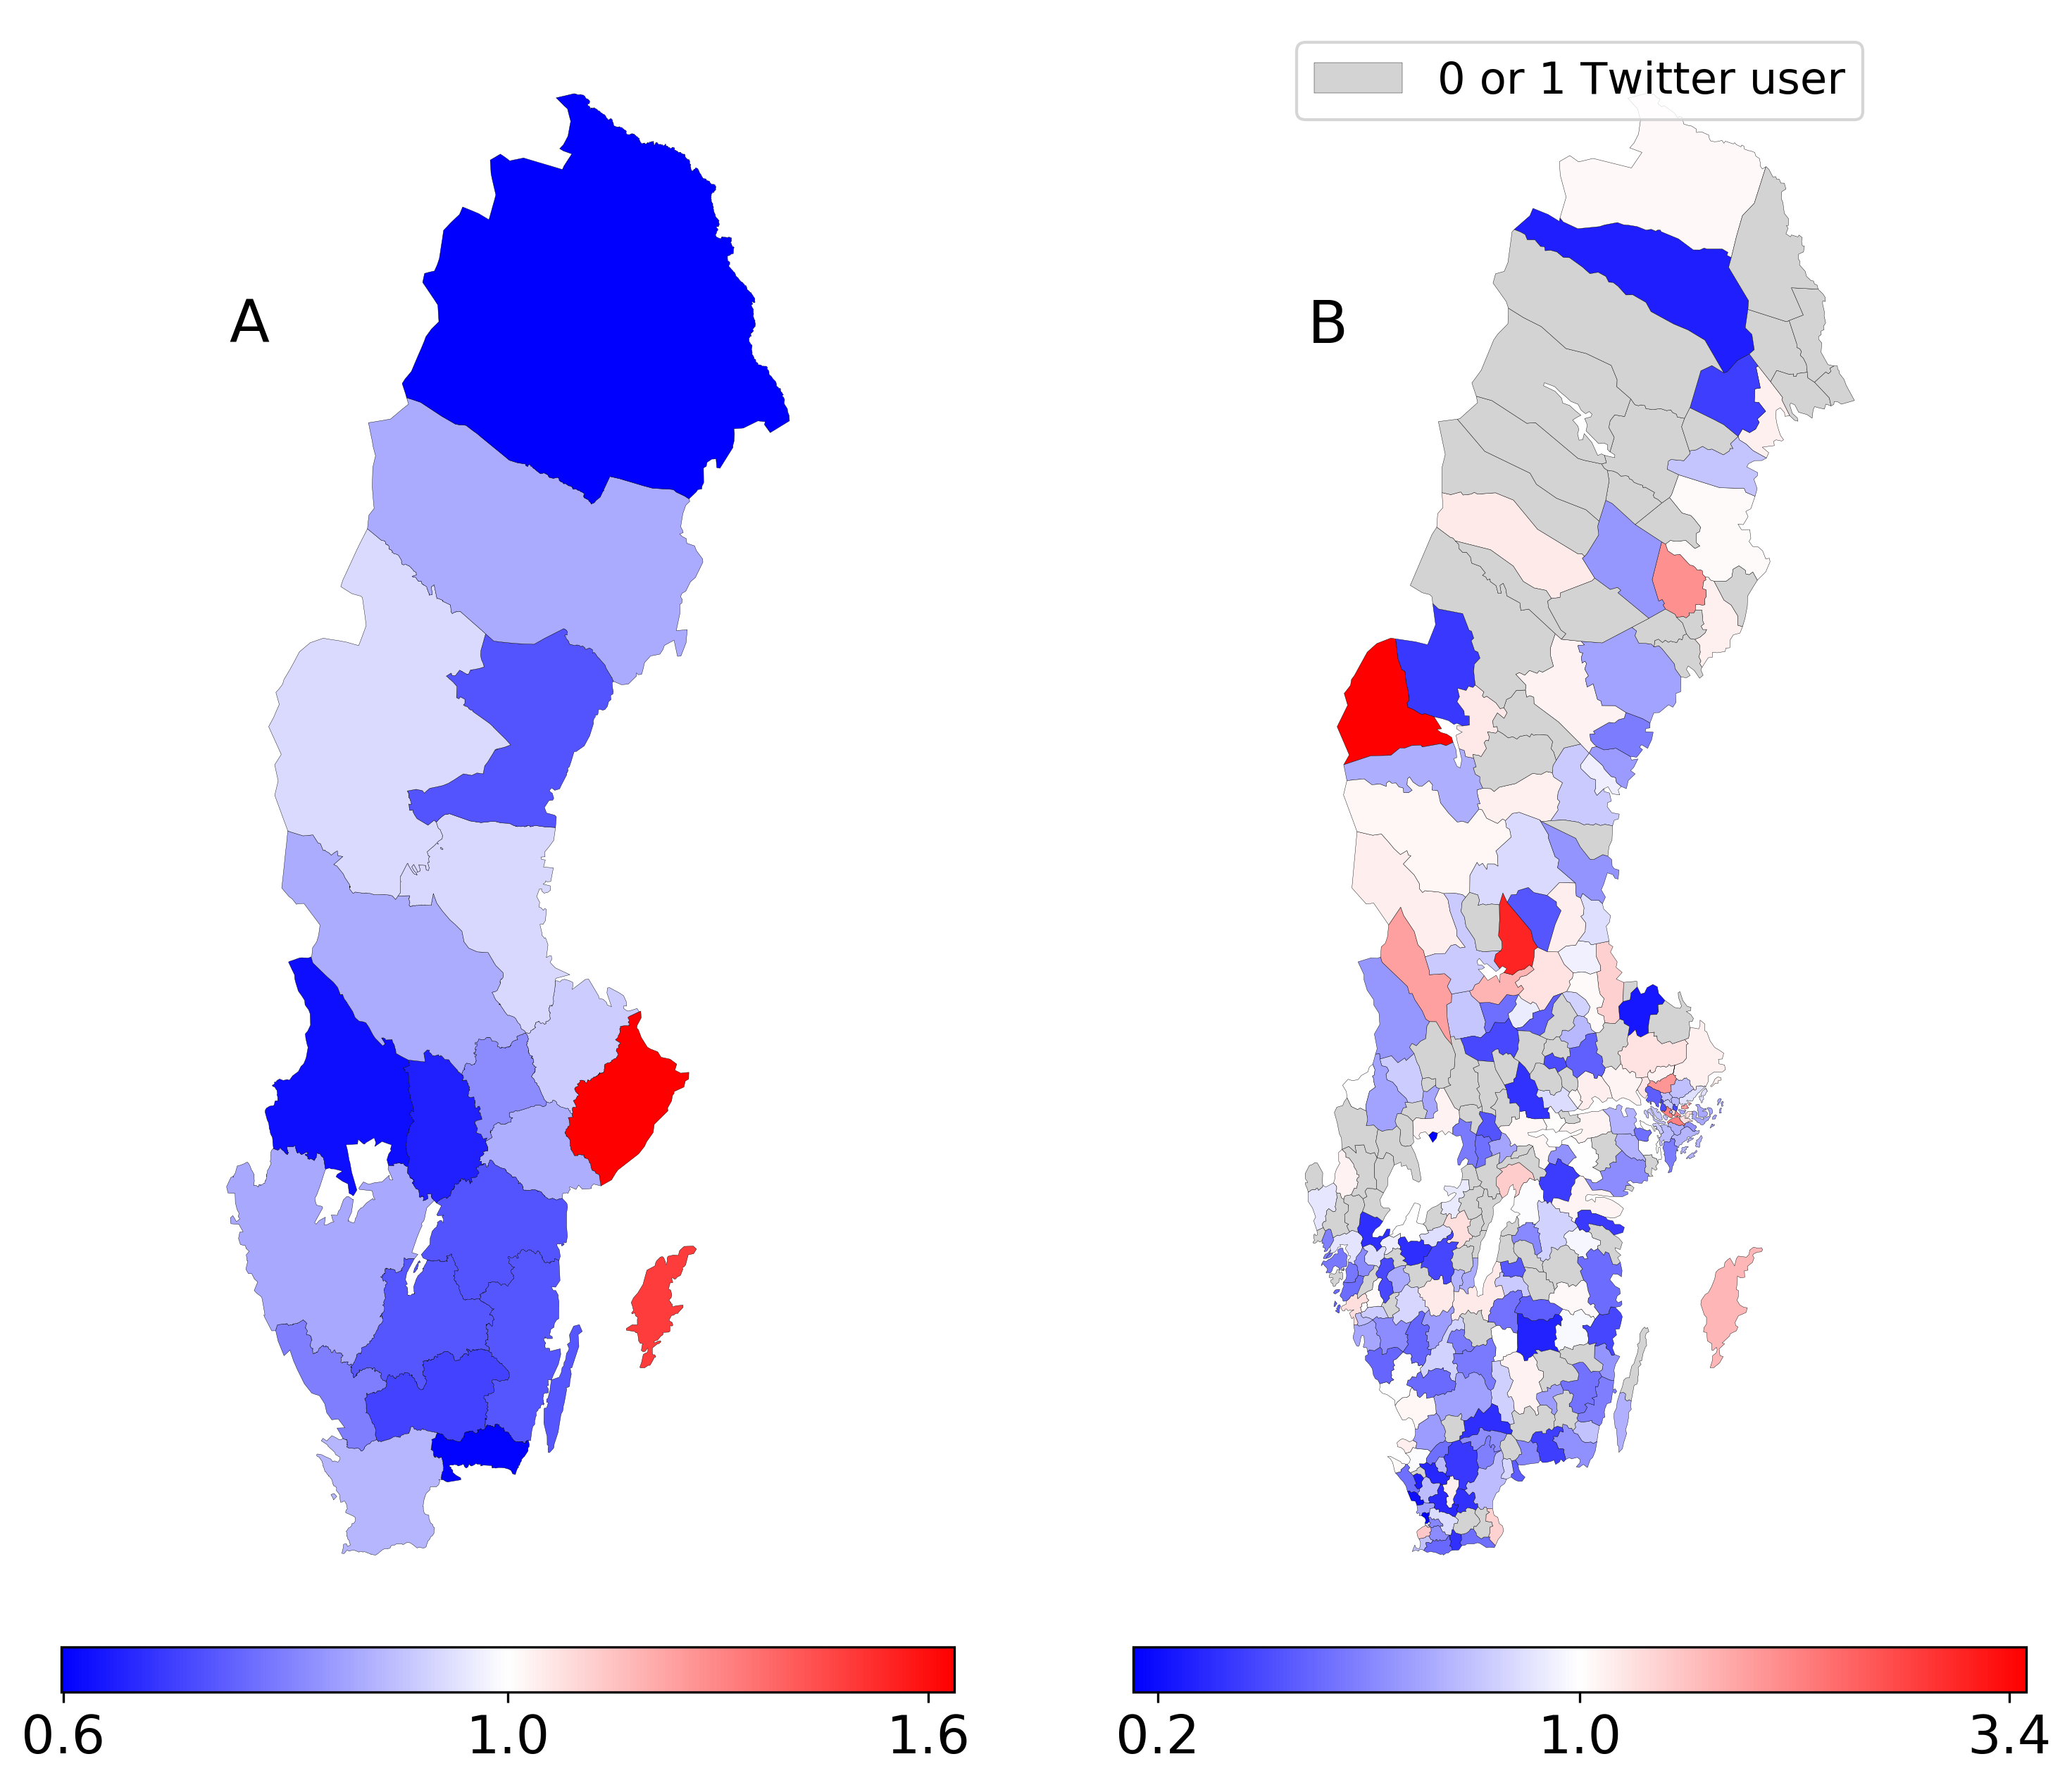

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12))
population_representation_plot(ax1, swe_counties, cbar_ticks=[.6, 1.0, 1.6])
ax1.text(.05, .8, "A", transform=ax1.transAxes, fontsize='20')
population_representation_plot(ax2, swe_municipalities, cbar_ticks=[.25, 1.0, 3.4])
ax2.text(.05, .8, "B", transform=ax2.transAxes, fontsize='20')

(1e-05, 0.5)

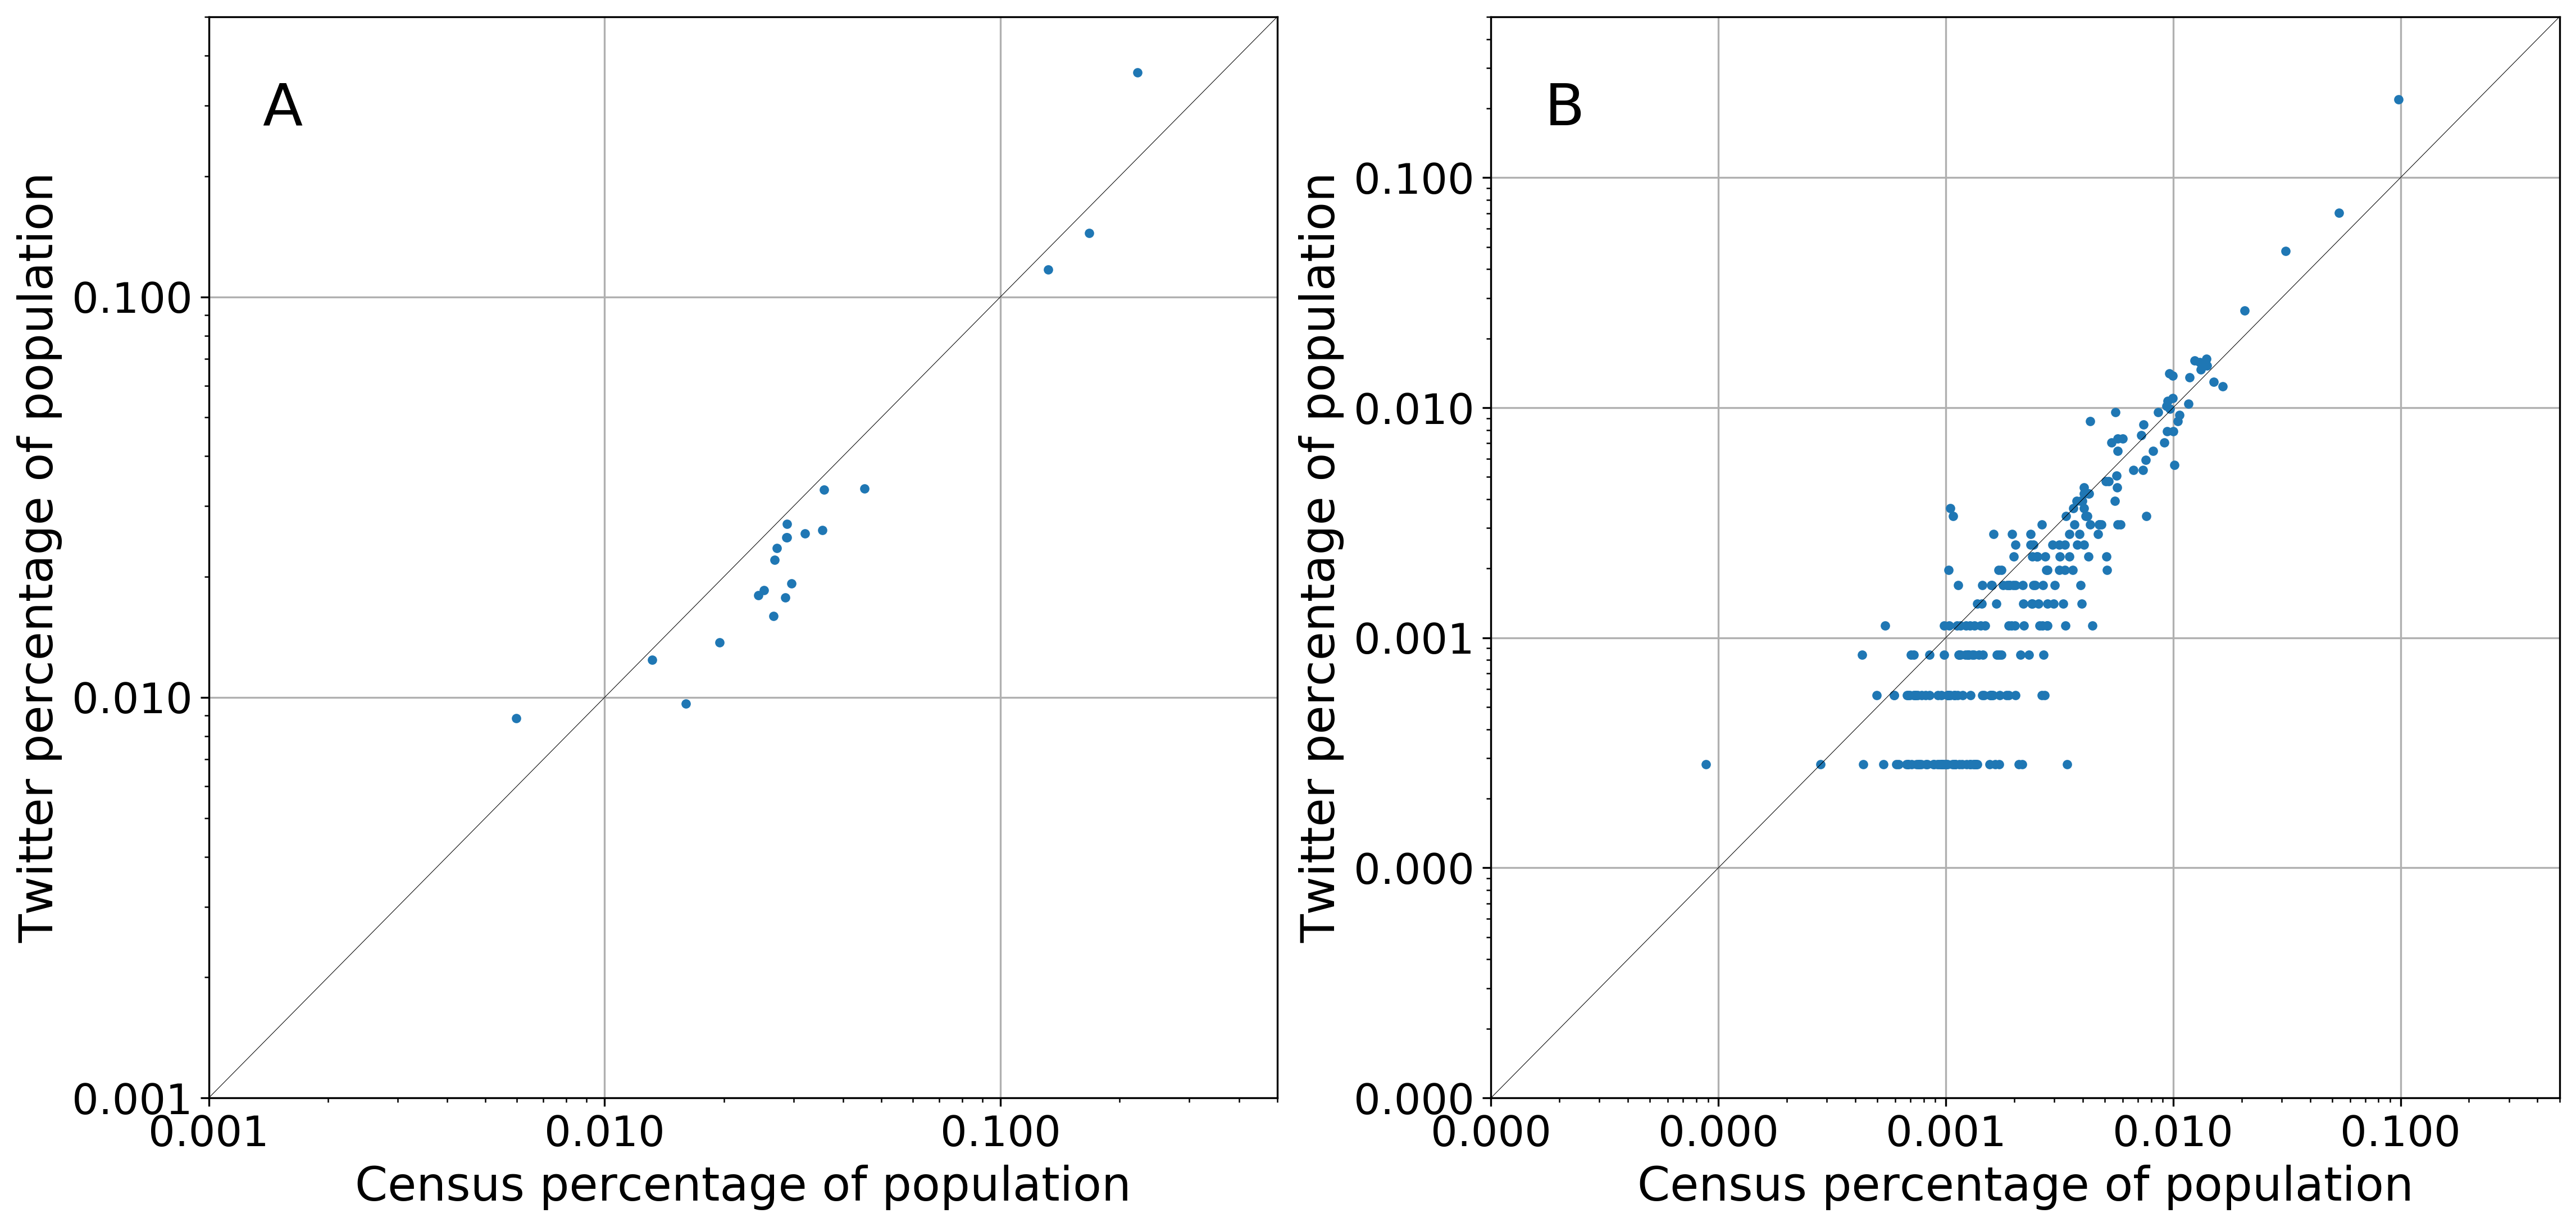

In [11]:
ax0, ax1 = poprep.plot_corr(swe_counties, swe_municipalities)
ax0.set_xlim((0.001, 0.5))
ax0.set_ylim((0.001, 0.5))
ax1.set_xlim((0.00001, 0.5))
ax1.set_ylim((0.00001, 0.5))

# Netherlands

In [12]:
# Load homes
neth_homes = poprep.twitter_home_locations("netherlands")
mask = netherlands.municipalities.to_crs("EPSG:3035").convex_hull.unary_union.convex_hull
neth_census_homes = geostat.load(mask=mask)

# Load shape files
neth_counties = netherlands.counties
neth_counties = neth_counties.rename(columns={'id':'ID'}).set_index('ID')
neth_counties = neth_counties[neth_counties['name'] != 'Caribbean Netherlands']

neth_municipalities = netherlands.municipalities
neth_municipalities = neth_municipalities.to_crs(neth_census_homes.crs)
neth_municipalities = neth_municipalities.rename(columns={'GM_CODE':'ID'}).set_index('ID')

# Align
neth_homes = neth_homes.to_crs(neth_census_homes.crs)
neth_counties = neth_counties.to_crs(neth_census_homes.crs)
neth_counties = poprep.align_populations(neth_counties, neth_homes, neth_census_homes)
neth_municipalities = poprep.align_populations(neth_municipalities, neth_homes, neth_census_homes)

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



In [13]:
neth_municipalities.sort_values(by="perc_of_census", ascending=False).head(5)

GM_NAAM WATER       OAD      STED  AANT_INW  AANT_MAN  \
ID                                                                   
GM0096      Vlieland   NEE       197         5      1085       533   
GM0096      Vlieland    JA -99999999 -99999999 -99999999 -99999999   
GM0093  Terschelling   NEE       241         5      4859      2579   
GM0093  Terschelling    JA -99999999 -99999999 -99999999 -99999999   
GM0363     Amsterdam   NEE      6004         1    844947    418127   

        AANT_VROUW  P_00_14_JR  P_15_24_JR  P_25_44_JR  ...  P_OVER_NW  \
ID                                                      ...              
GM0096         552          13          12          23  ...          1   
GM0096   -99999999   -99999999   -99999999   -99999999  ...  -99999999   
GM0093        2280          12          17          21  ...          1   
GM0093   -99999999   -99999999   -99999999   -99999999  ...  -99999999   
GM0363      426820          15          13          35  ...         12   

         OPP_TOT  OPP_LAND  OPP_WATER  \
ID                                      
GM0096     31580      3544      28036   
GM0096 -99999999 -99999999  -99999999   
GM0093     67399      8345      59054   
GM0093 -99999999 -99999999  -99999999   
GM0363     21949     16533       5416   

                                                 geometry  twitter  census  \
ID                                                                           
GM0096  MULTIPOLYGON (((3996862.062 3365674.670, 39968...      4.0    2300   
GM0096  MULTIPOLYGON (((3993268.890 3365382.665, 39932...      4.0    2300   
GM0093  MULTIPOLYGON (((4003813.033 3359482.135, 40038...      8.0    7539   
GM0093  POLYGON ((4025876.409 3382805.375, 4027775.457...      8.0    7539   
GM0363  MULTIPOLYGON (((3981727.534 3262982.518, 39817...    790.0  861652   

        twitter_perc  census_perc  perc_of_census  
ID                                                 
GM0096      0.000557     0.000088        6.355910  
GM0096      0.000557     0.000088        6.355910  
GM0093      0.001113     0.000287        3.878125  
GM0093      0.001113     0.000287        3.878125  
GM0363      0.109921     0.032805        3.350740  

[5 rows x 38 columns]

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/geopandas/plotting.py:332: UserWarning:

The GeoSeries you are attempting to plot is empty. Nothing has been displayed.



Text(0.05, 0.8, 'B')

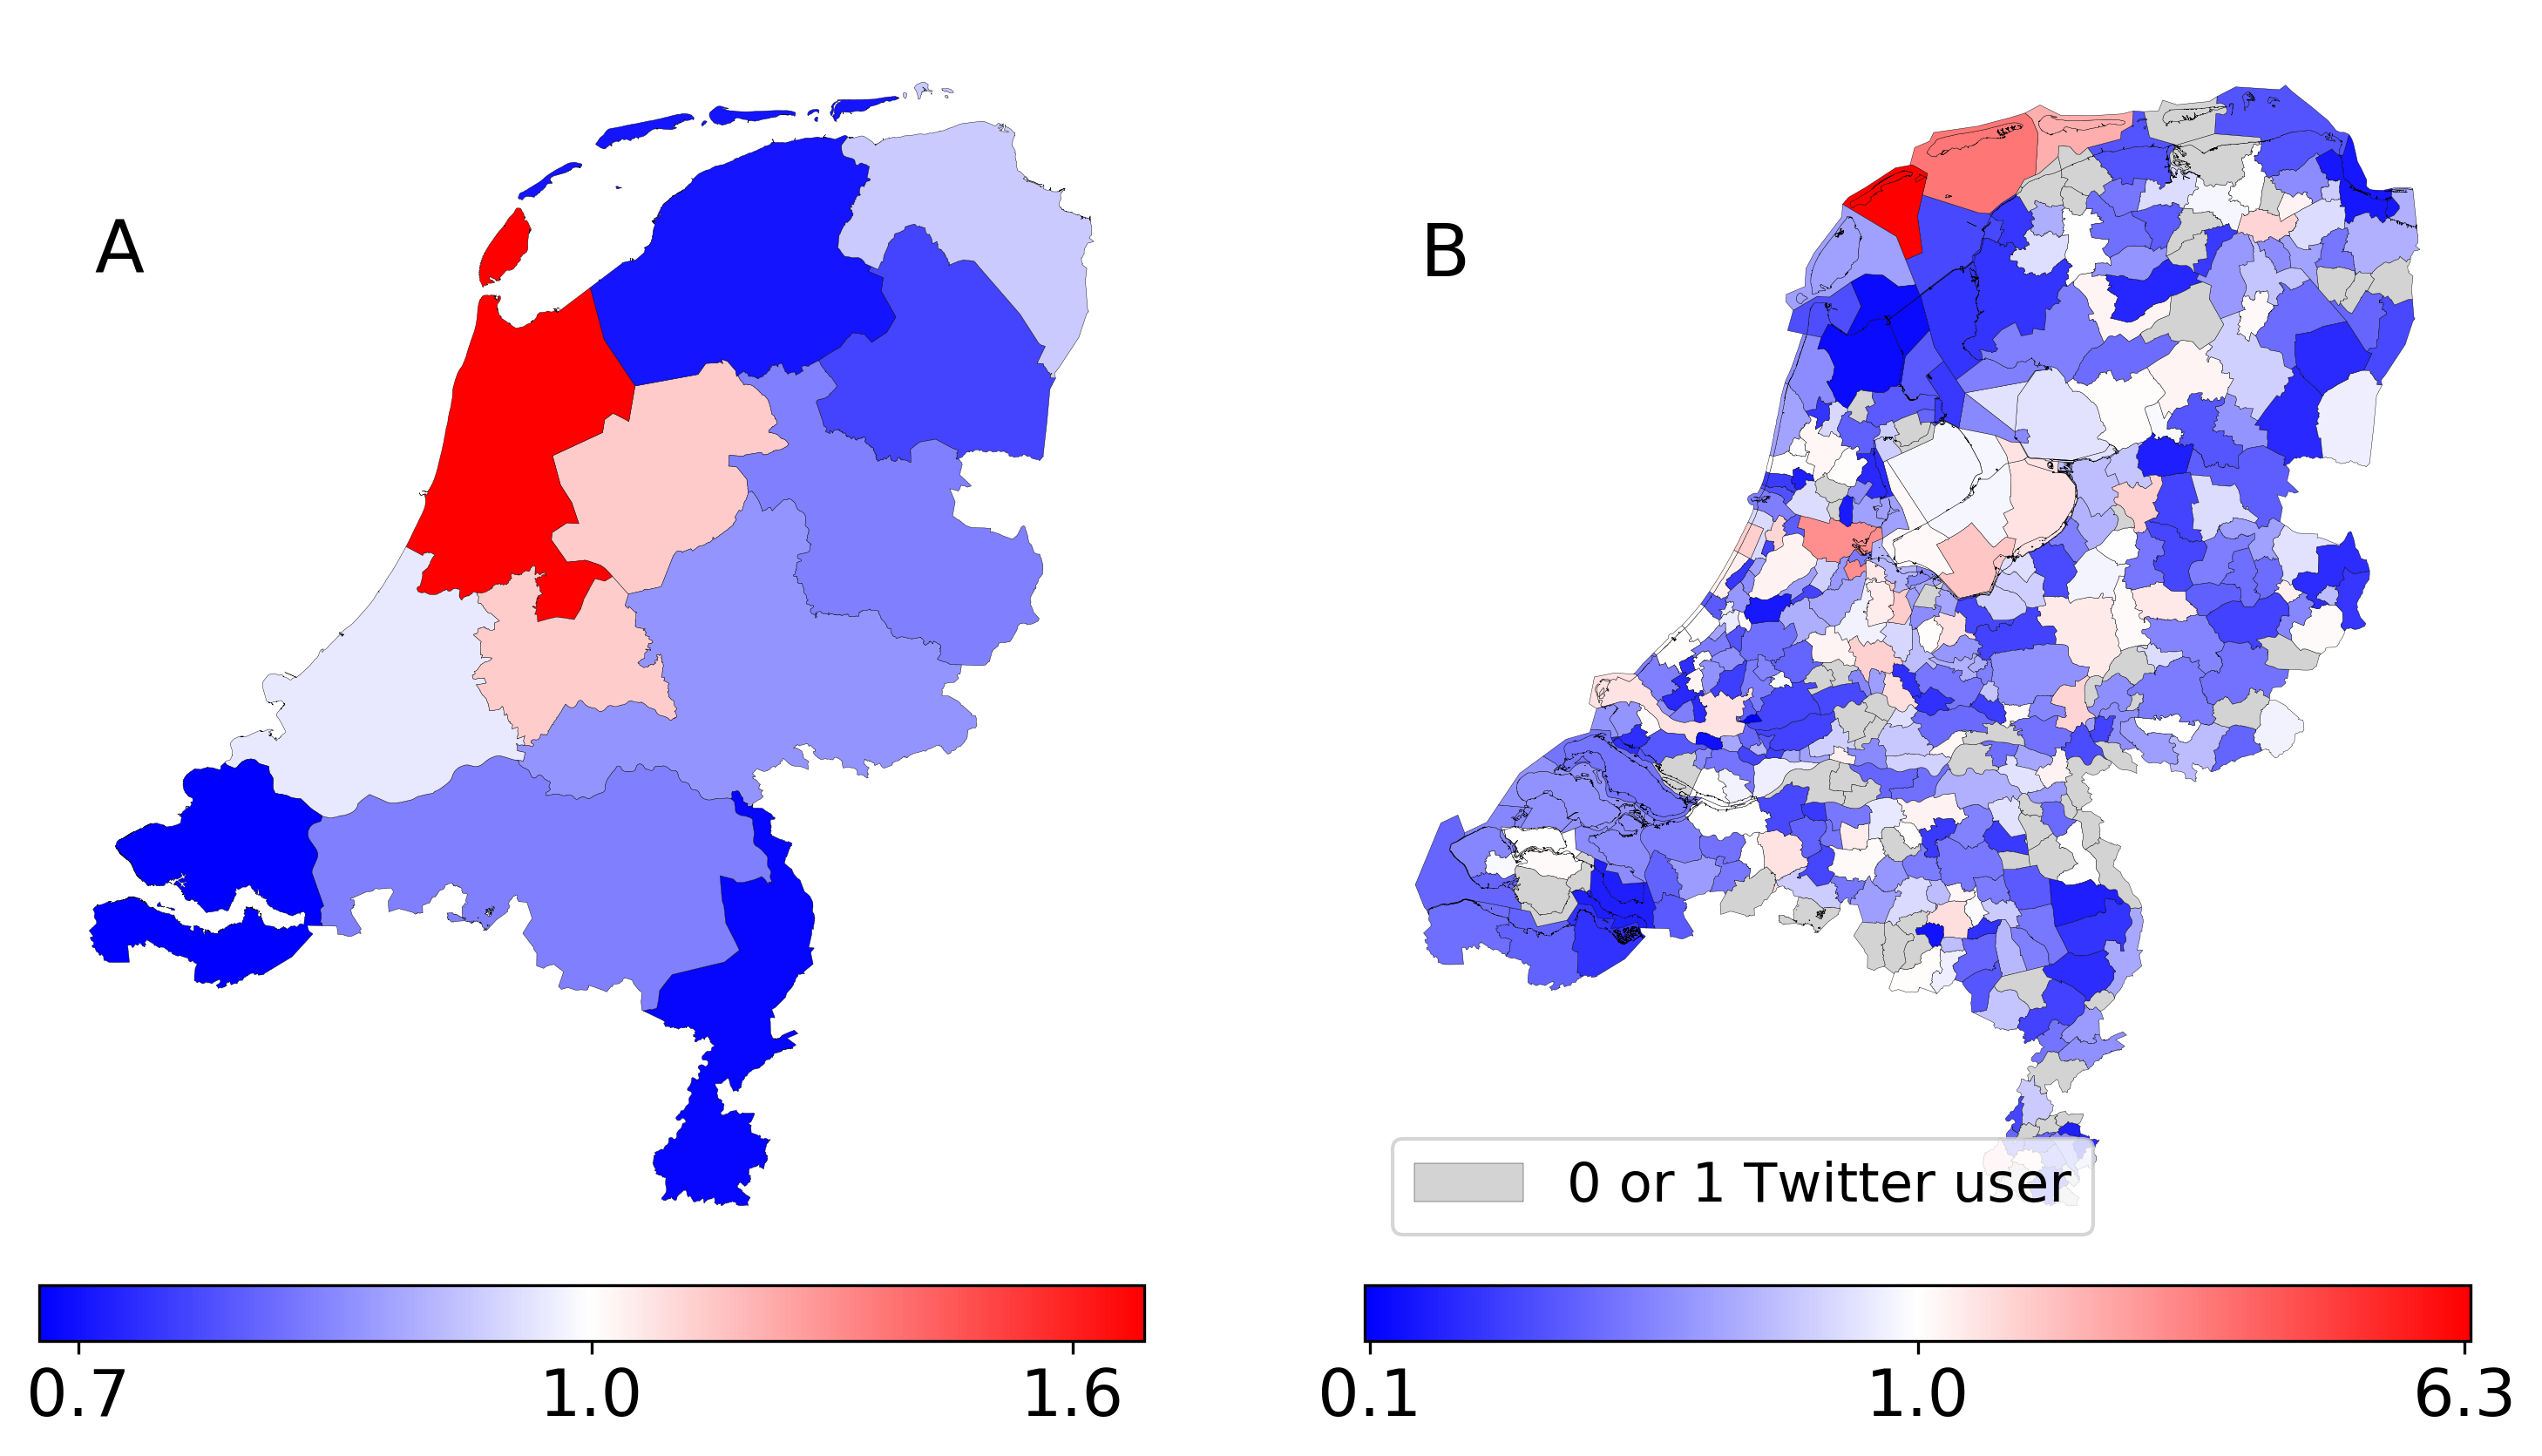

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12))
population_representation_plot(ax1, neth_counties, cbar_ticks=[.65, 1.0, 1.6])
ax1.text(.05, .8, "A", transform=ax1.transAxes, fontsize='20')
population_representation_plot(ax2, neth_municipalities, cbar_ticks=[.15, 1.0, 6.3],label_loc="lower left")
ax1.text(.05, .8, "B", transform=ax2.transAxes, fontsize='20')

(1e-05, 0.5)

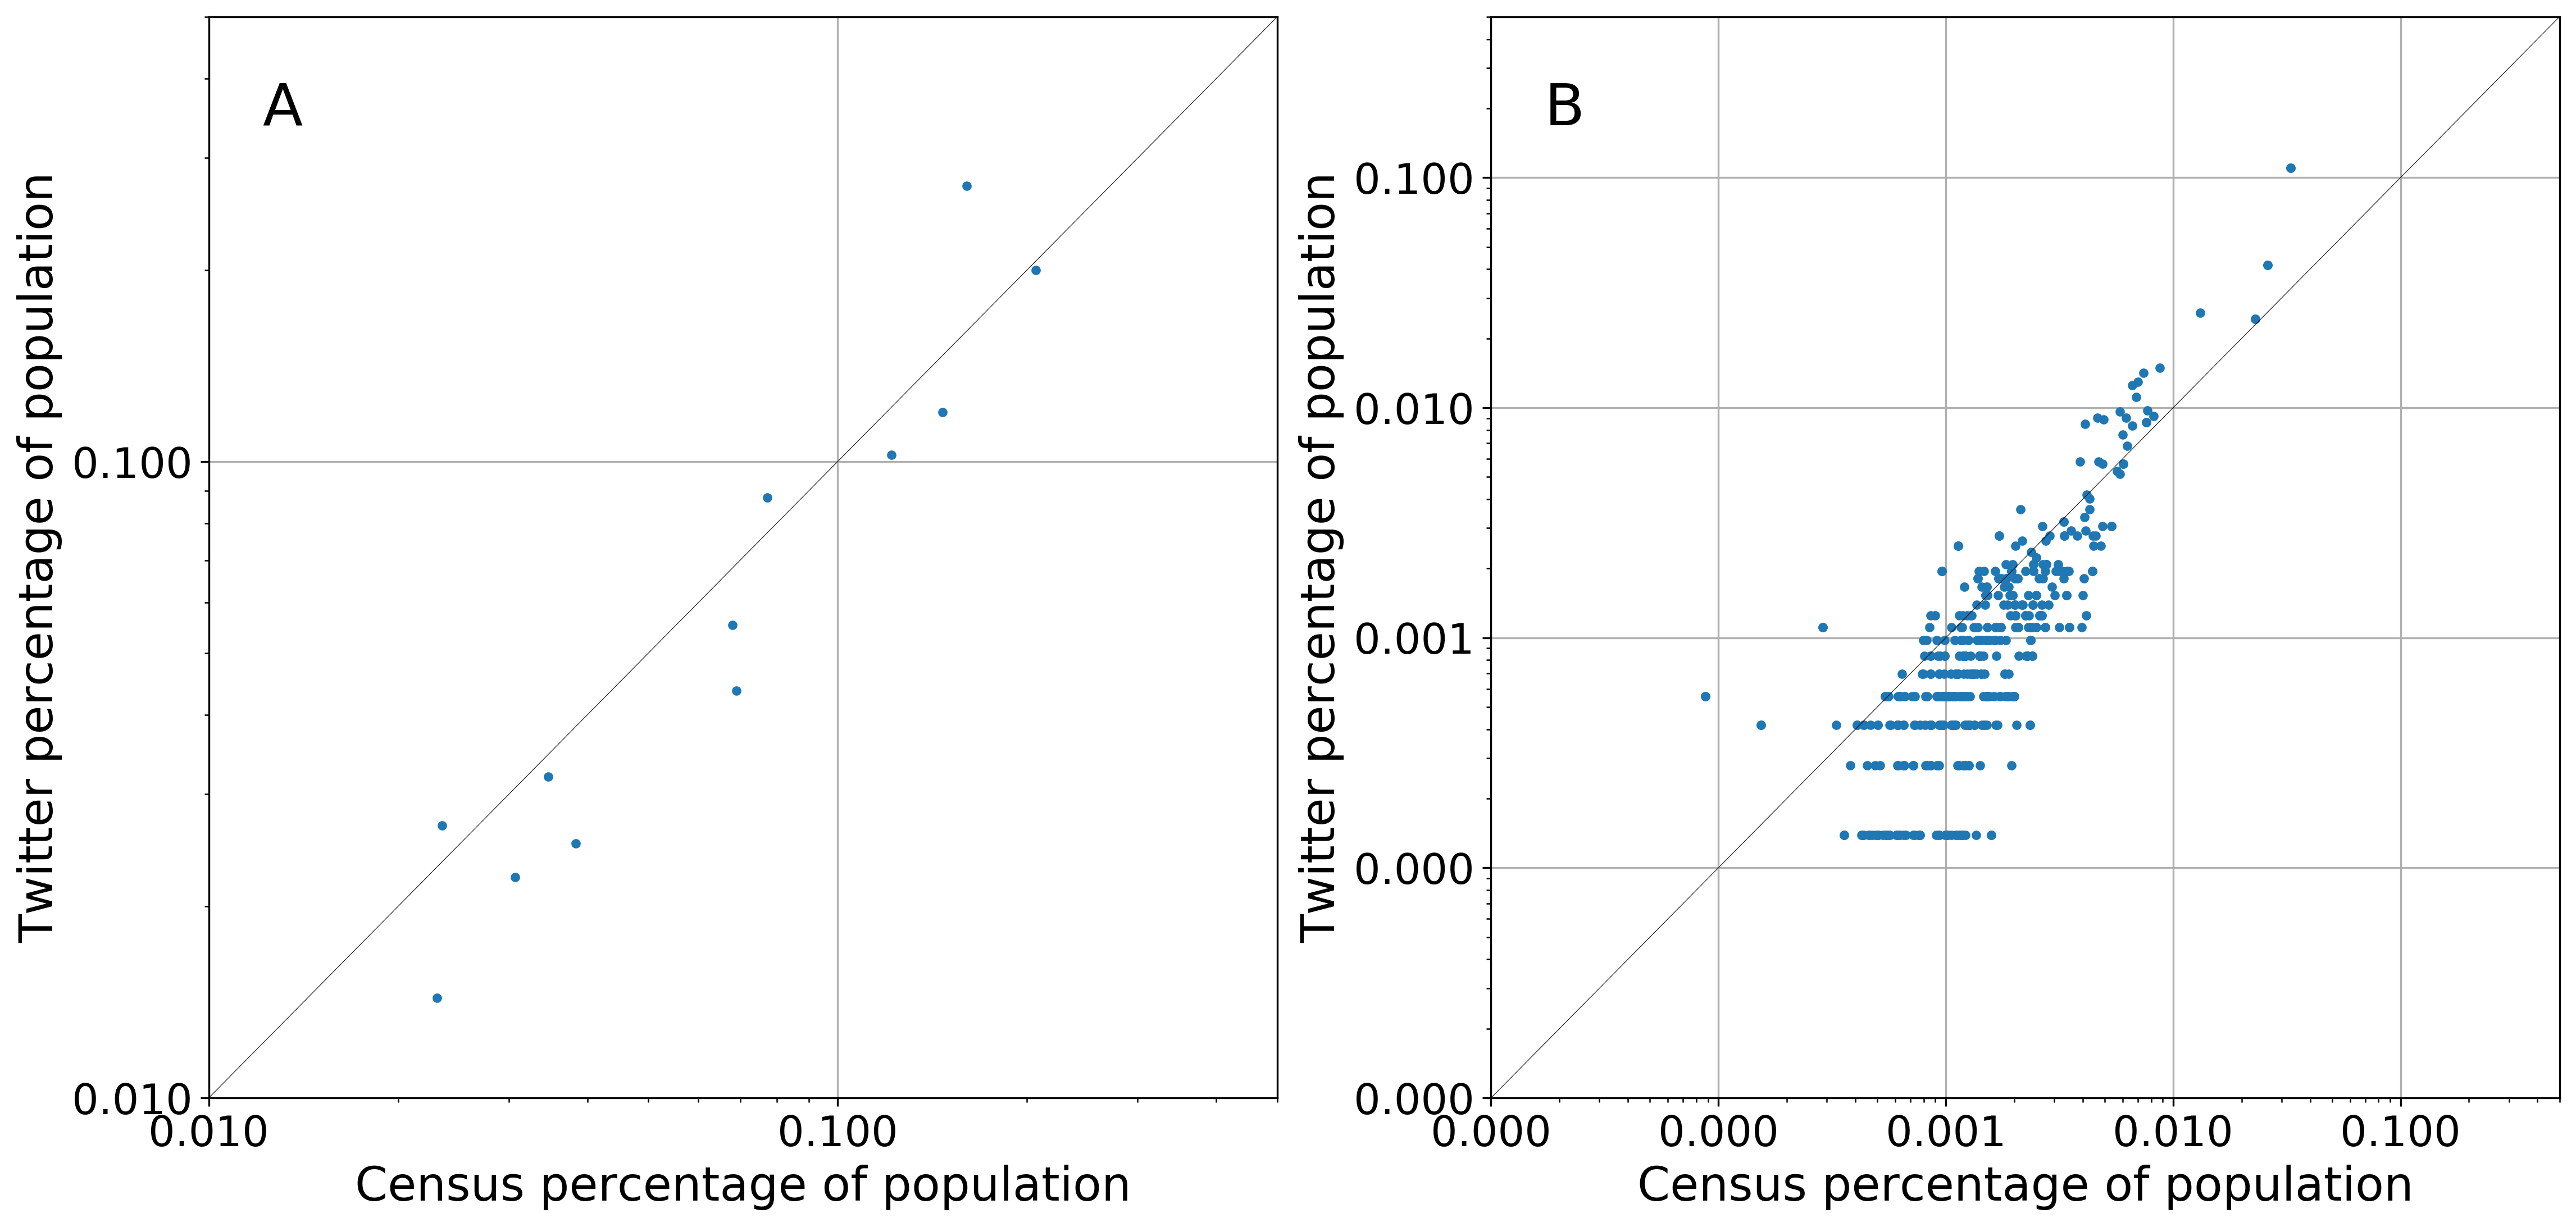

In [15]:
ax0, ax1 = poprep.plot_corr(neth_counties, neth_municipalities)
ax0.set_xlim((0.01, 0.5))
ax0.set_ylim((0.01, 0.5))
ax1.set_xlim((0.00001, 0.5))
ax1.set_ylim((0.00001, 0.5))

# Sao Paulo

In [16]:
# Load homes
sao_homes = poprep.twitter_home_locations("saopaulo")
sao_census_homes = saopaulo.zone_populations()
sao_census_homes = sao_census_homes[sao_census_homes['census_population'] != 0.]

# Align
sao_homes = sao_homes.to_crs(saopaulo.metric_epsg)
sao_study_zone = poprep.align_populations_aus_sao(sao_census_homes, sao_homes)

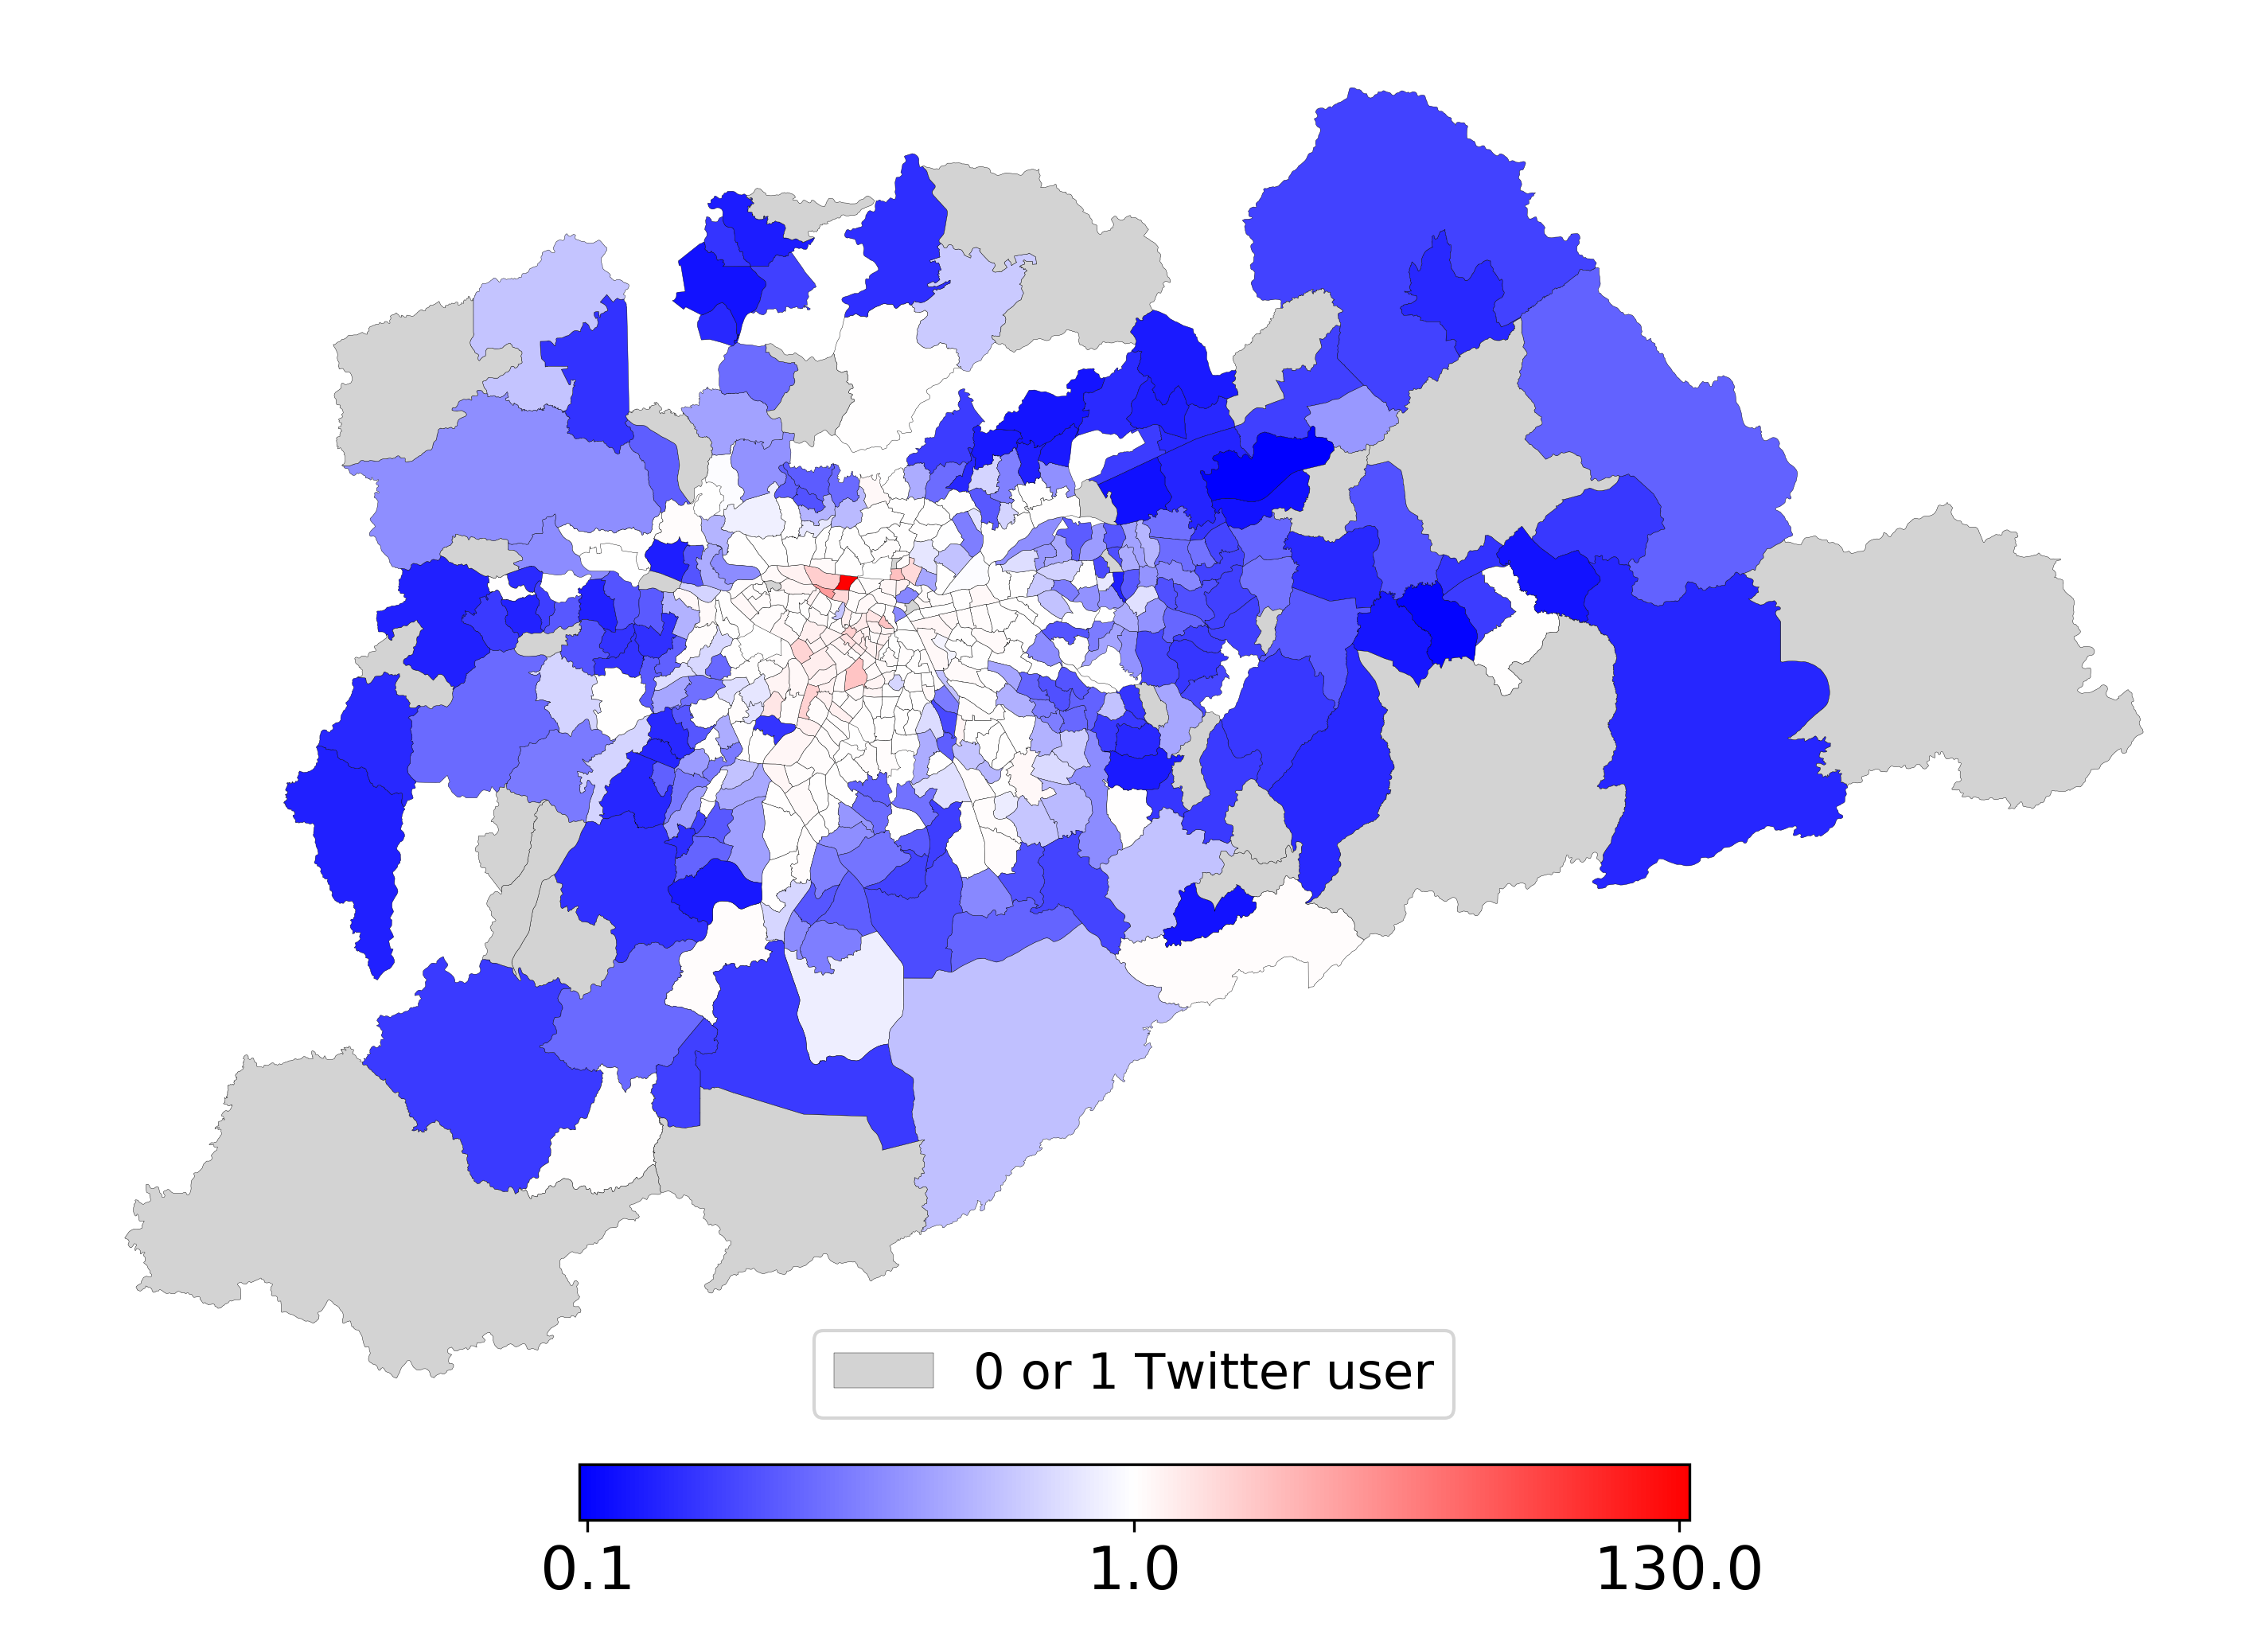

In [18]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
population_representation_plot(
    ax, 
    sao_study_zone, 
    cbar_ticks=[0.05, 1.0, 130],
    label_loc="lower center",
    colorbar_shrink=0.5
)

(1e-05, 0.5)

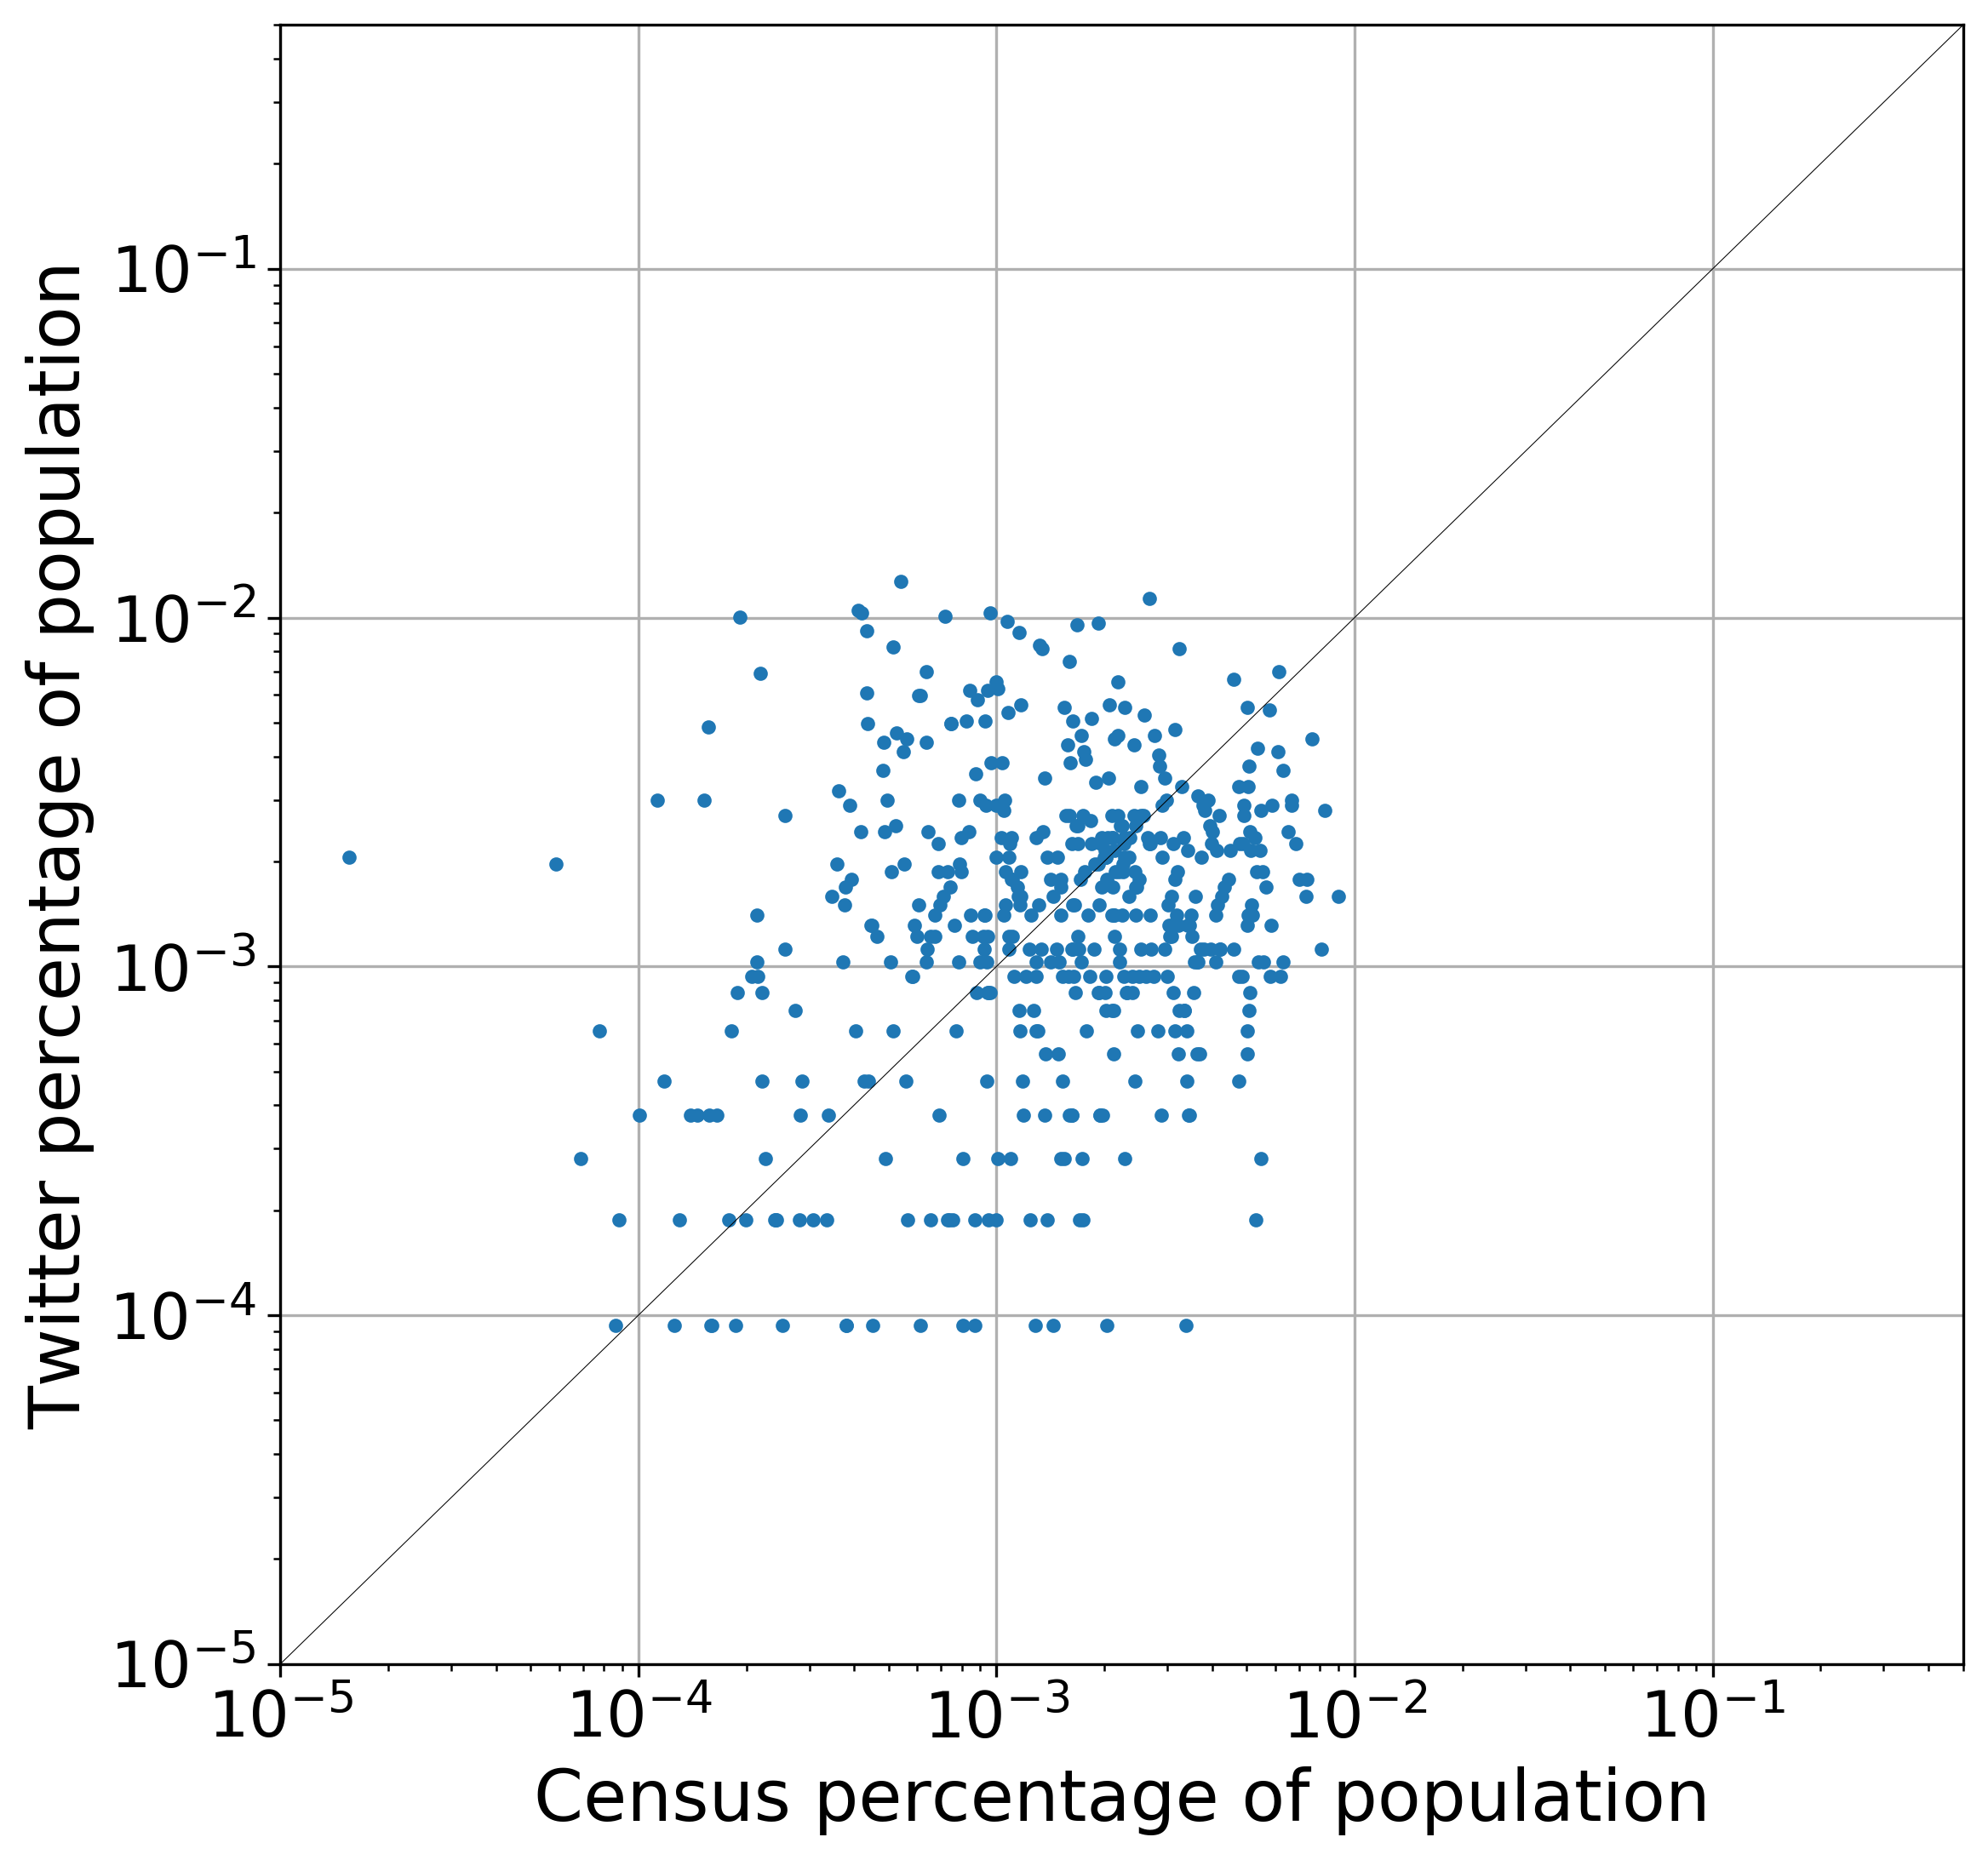

In [19]:
ax = poprep.plot_corr_aus_sao(sao_study_zone)
ax.set_xlim((0.00001, 0.5))
ax.set_ylim((0.00001, 0.5))

# Australia

In [20]:
# Load homes
aus_homes = poprep.twitter_home_locations("australia")
aus_census_homes = australia.zone_populations()
aus_census_homes = aus_census_homes[aus_census_homes['census_population'] != 0.]

# Align
aus_homes = aus_homes.to_crs(australia.metric_epsg)
aus_study_zone = poprep.align_populations_aus_sao(aus_census_homes, aus_homes)

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/geopandas/plotting.py:332: UserWarning:

The GeoSeries you are attempting to plot is empty. Nothing has been displayed.



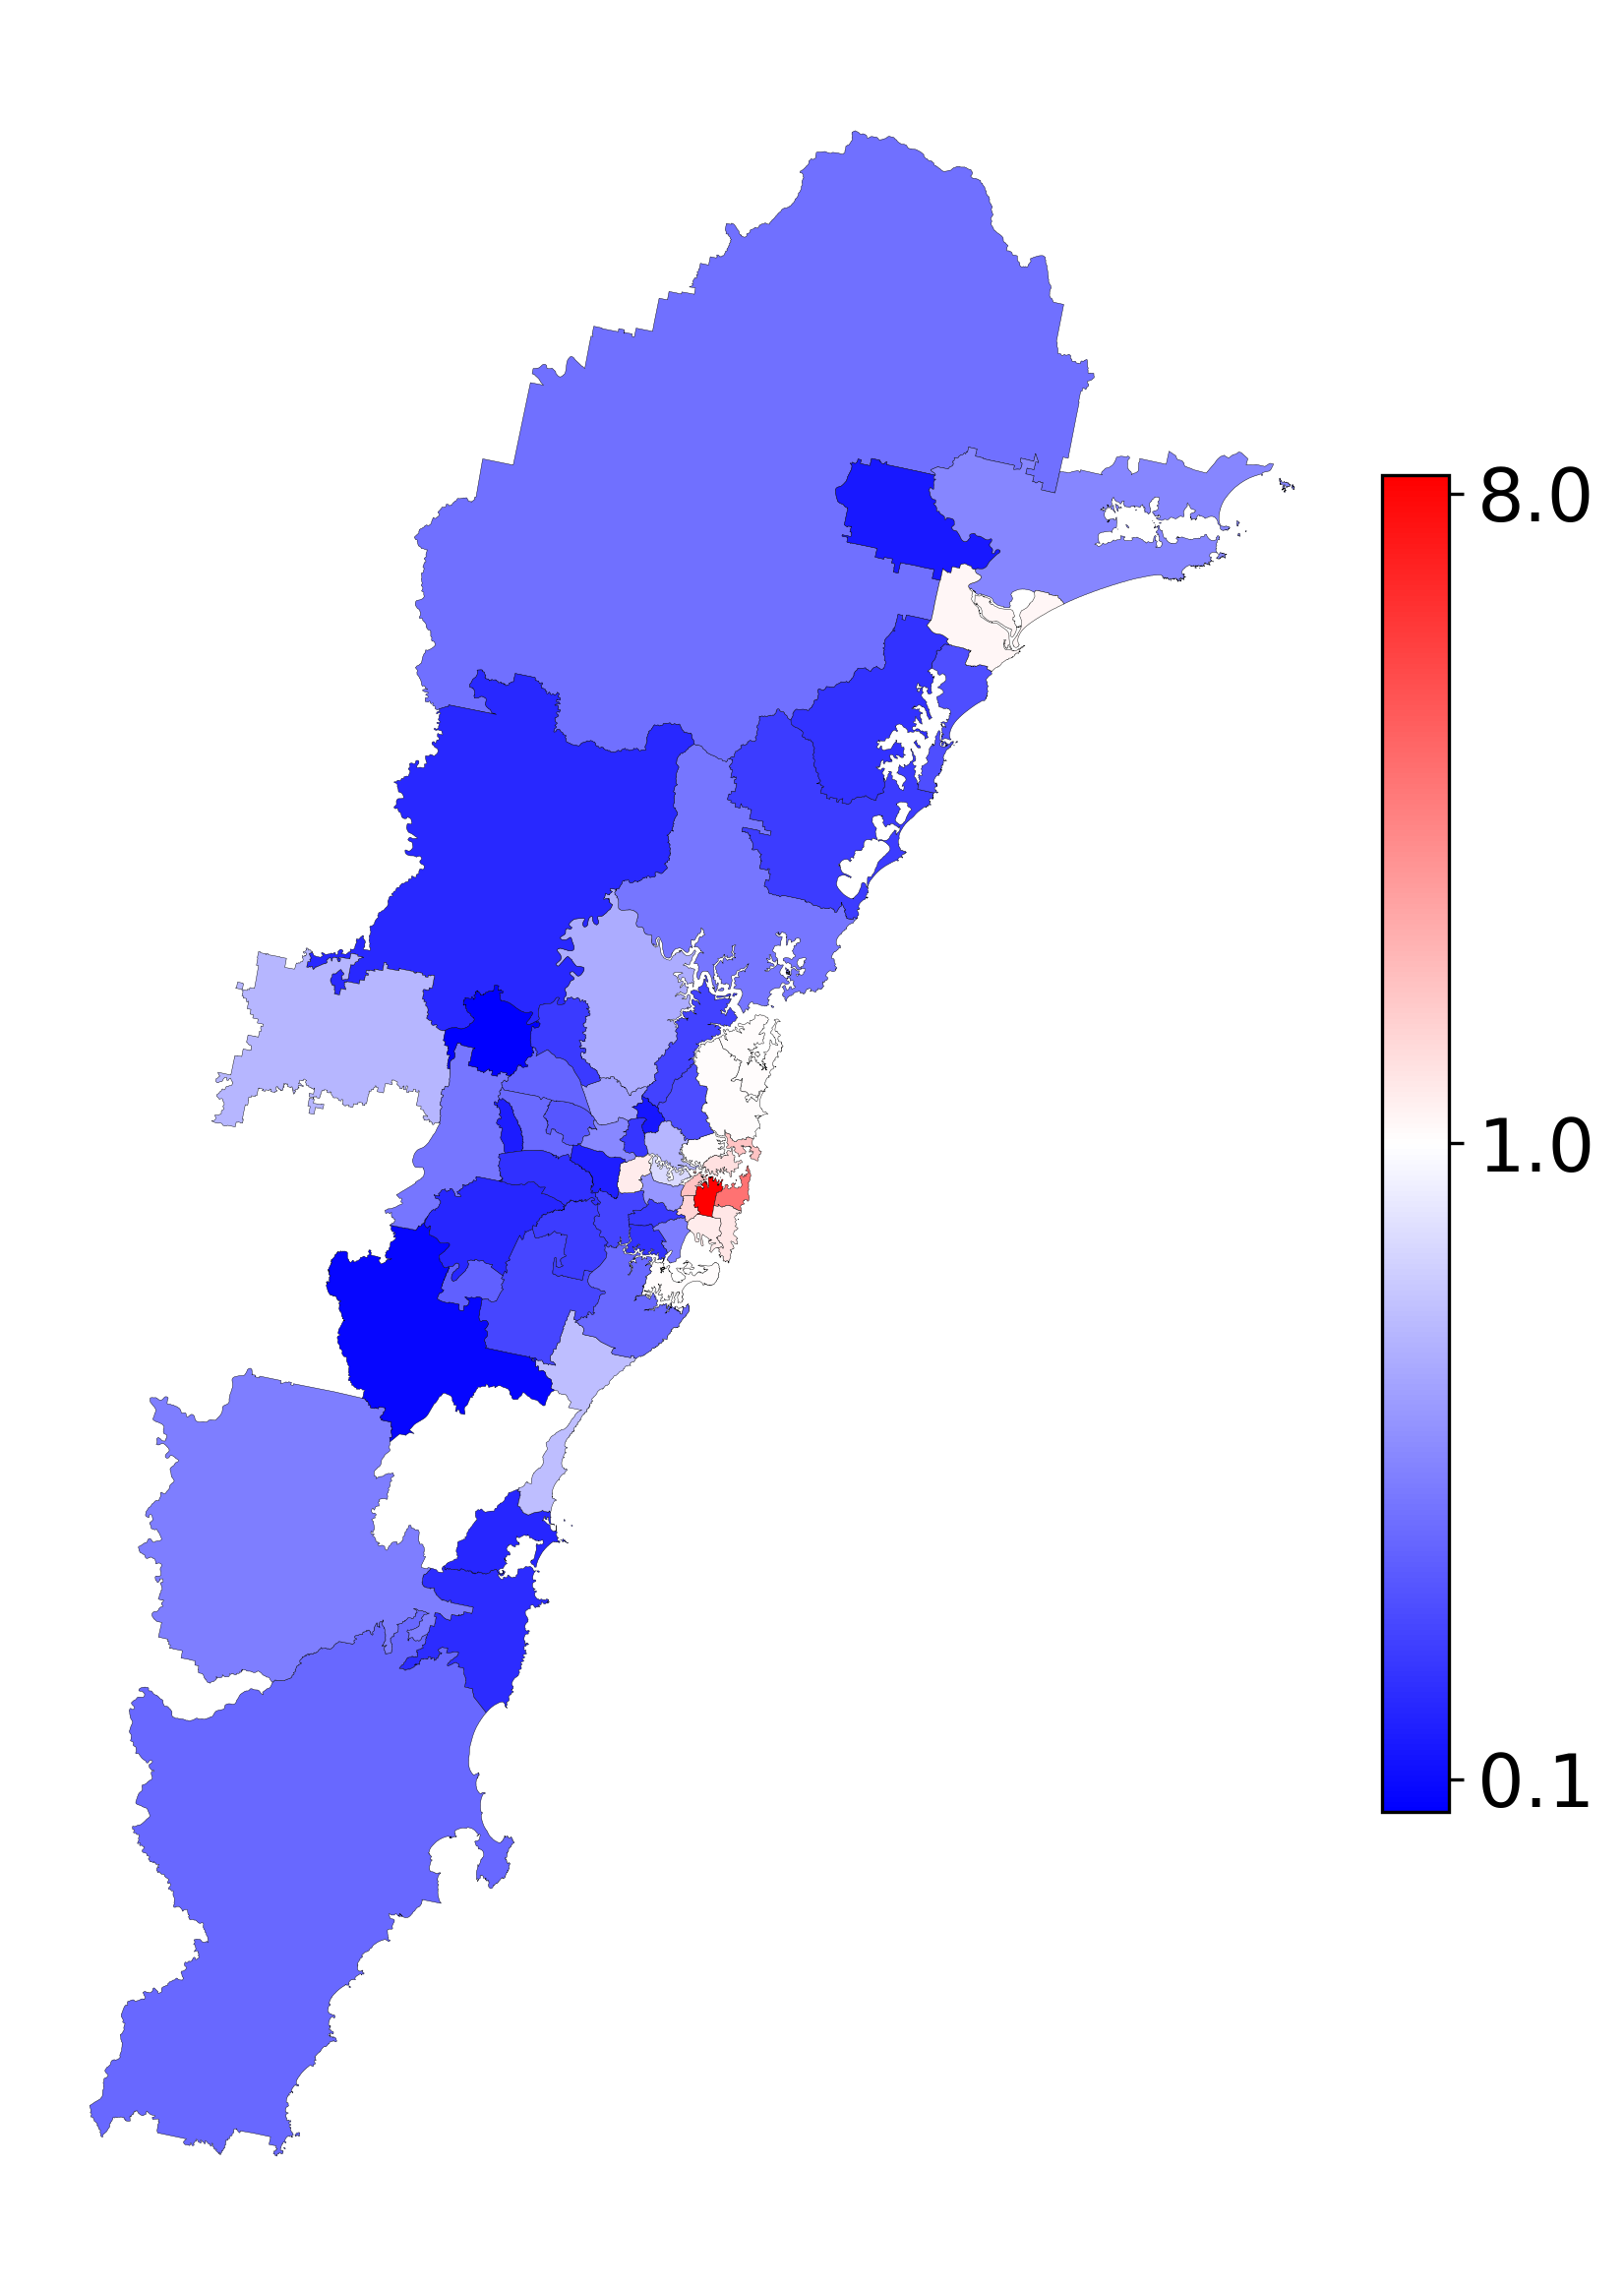

In [22]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
population_representation_plot(
    ax,
    aus_study_zone,
    cbar_ticks=[.15, 1.0, 8],
    colorbar_orientation="vertical",
    colorbar_shrink=0.6,
)

(0.0005, 0.5)

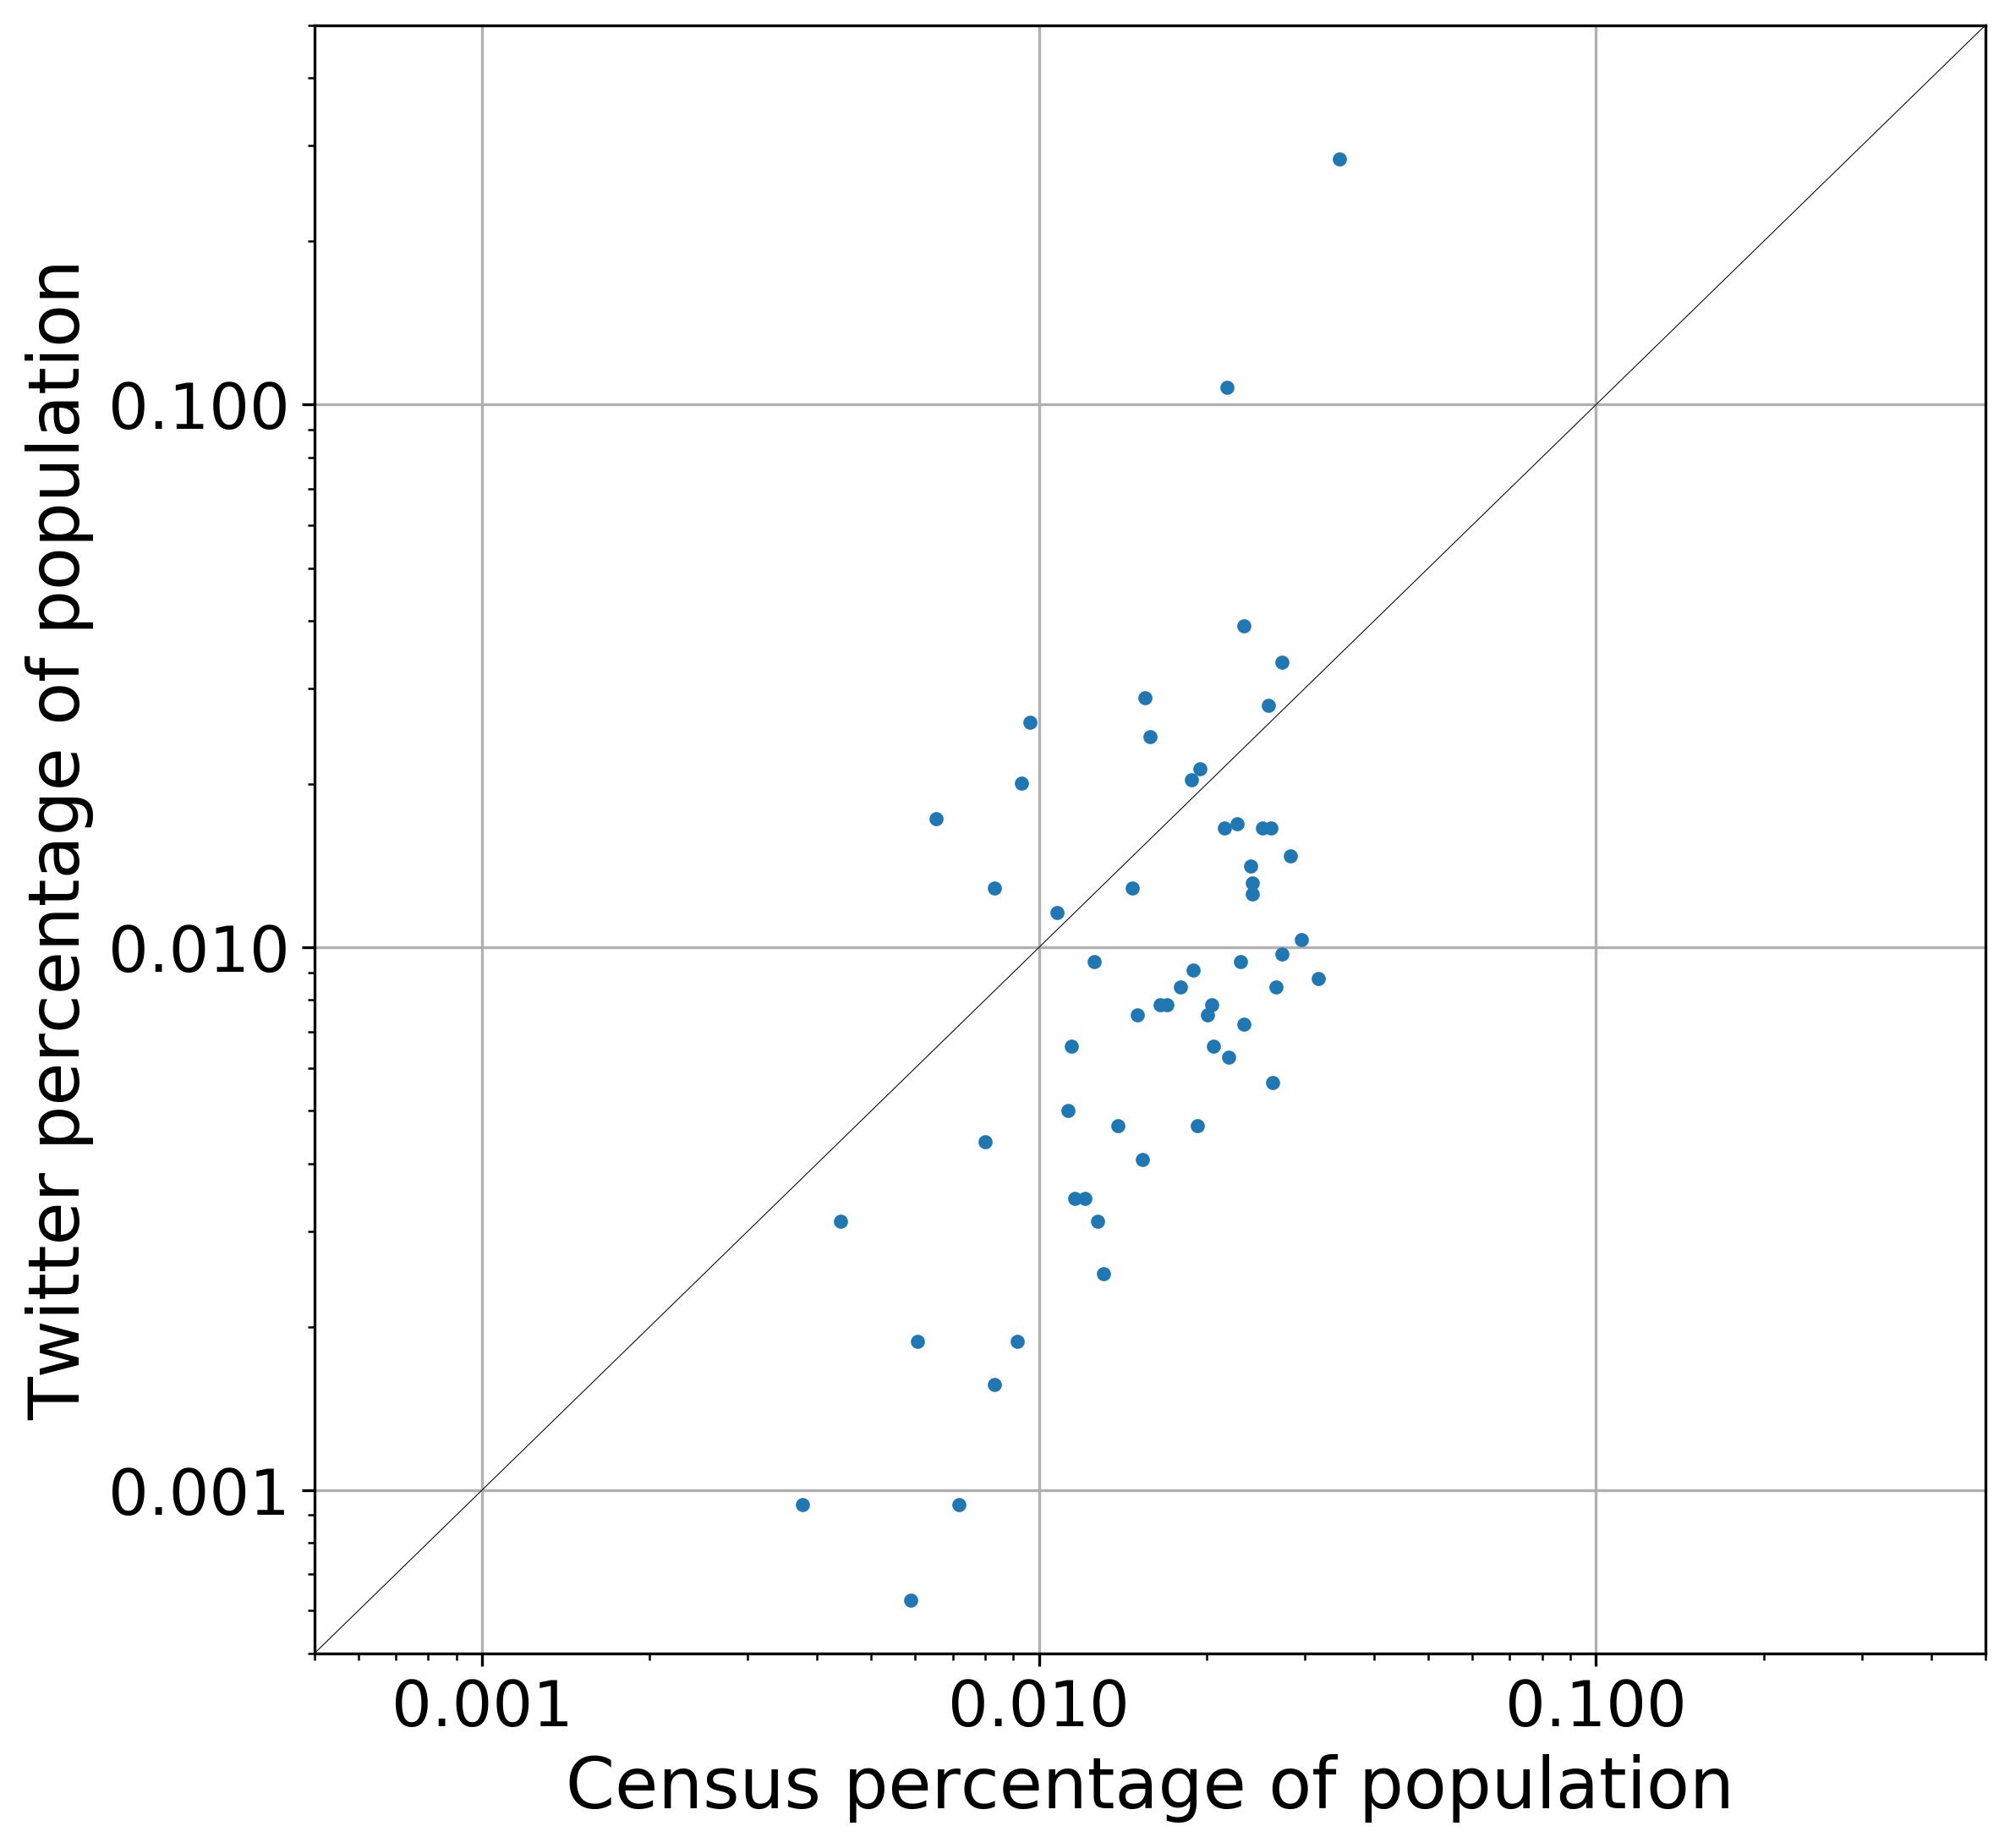

In [26]:
from matplotlib.ticker import ScalarFormatter
ax = poprep.plot_corr_aus_sao(aus_study_zone)
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_xlim((0.0005, 0.5))
ax.set_ylim((0.0005, 0.5))